The scheme to implement a model with keras:

* Architecture of the model
* Compiling the model
* Training of the model Diagnosis of the training
* Evaluation of predictions

In [17]:
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.cm as cm
%matplotlib inline

* loading and preprocessing the dataset

In [2]:
dataset_path = '../../../IAM_Words/words'  # Update the path as necessary
data = []
words = open("../ascii/words.txt", "r").readlines()
inexistent_or_corrupted= 0

for line in tqdm(words):
    if line.startswith("#"):
        continue
    parts = line.strip().split()
    fixed_part = parts[:8]
    transcription_part = ' '.join(parts[8:])

    line_split = line.split(" ")
    folder_parts = line_split[0].split('-')
    folder1 = folder_parts[0]
    folder2 = folder_parts[0] + '-' + folder_parts[1]
    file_name = line_split[0] + ".png"
    label = line_split[-1].rstrip('\n')
    rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

    if os.path.exists(rel_path) and os.path.getsize(rel_path) > 0:
        data.append(fixed_part + [transcription_part, rel_path])
    else:
        inexistent_or_corrupted += 1

print('inexistent_or_corrupted', inexistent_or_corrupted)
df = pd.DataFrame(data, columns=['line_id', 'result', 'graylevel', 'x', 'y', 'w', 'h', 'annotation', 'transcription', 'image_path'])
display(df.head())

100%|██████████| 115338/115338 [00:01<00:00, 74707.47it/s]


inexistent_or_corrupted 2


,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../../IAM_Words/words/a01/a01-000u/a01-000u...
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../../IAM_Words/words/a01/a01-000u/a01-000u...
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../../IAM_Words/words/a01/a01-000u/a01-000u...
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../../IAM_Words/words/a01/a01-000u/a01-000u...
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../../IAM_Words/words/a01/a01-000u/a01-000u...


* check transcription distribution and remove transcriptions with fewer than 2 samples 

In [3]:
# Check transcription distribution
print("Transcription distribution before filtering:")
print(df['transcription'].value_counts())

# Remove transcription with fewer than 2 samples
min_samples = 2
class_counts = df['transcription'].value_counts()
classes_to_keep = class_counts[class_counts >= min_samples].index
df_filtered = df[df['transcription'].isin(classes_to_keep)].copy()
# reset index after manipulation
df_filtered.reset_index(drop=True, inplace=True)

# Check transcription distribution after filtering
print("Transcription distribution after filtering:")
print(df_filtered['transcription'].value_counts())

le = LabelEncoder()
df_filtered['transcription_encoded'] = None
df_filtered['transcription_encoded'] = le.fit_transform(df_filtered['transcription'])

display(df_filtered.info())
display(df_filtered.head())

Transcription distribution before filtering:
transcription
the           5826
,             5570
.             4984
of            3192
to            2651
              ... 
dimensions       1
painting         1
cutters          1
Parana           1
hullo            1
Name: count, Length: 13550, dtype: int64
Transcription distribution after filtering:
transcription
the          5826
,            5570
.            4984
of           3192
to           2651
             ... 
specified       2
palm            2
smoothing       2
gate            2
doorman         2
Name: count, Length: 6360, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108128 entries, 0 to 108127
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   line_id                108128 non-null  object
 1   result                 108128 non-null  object
 2   graylevel              108128 non-null  object
 3   x                  

None

,line_id,result,graylevel,x,y,w,h,annotation,transcription,image_path,transcription_encoded
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,../../../IAM_Words/words/a01/a01-000u/a01-000u...,116
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,../../../IAM_Words/words/a01/a01-000u/a01-000u...,850
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,../../../IAM_Words/words/a01/a01-000u/a01-000u...,5884
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,../../../IAM_Words/words/a01/a01-000u/a01-000u...,5573
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,../../../IAM_Words/words/a01/a01-000u/a01-000u...,930


* preparing image data

In [4]:
X, Y = [], []
width, height = 28, 28  # Resize to 28x28

for index, row in df_filtered.iterrows():
    # print(image.mode)
    image = Image.open(row['image_path']).convert('L').resize((width, height))
    X.append(np.array(image))
    Y.append(row['transcription_encoded'])

X = np.array(X) / 255.0  # Normalize images
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))
Y = np.array(Y)

print('X and Y have the same length ',len(X) == len(Y))
'''
X, Y = [], []
width, height = 28, 28
for index, row in df_filtered.iterrows():
    gray_image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2GRAY)
    image = cv2.resize(gray_image, (width, height))
    X.append(np.array(image)) 
    Y.append(row['transcription_encoded'])'''


Min: 0.000, Max: 1.000
X and Y have the same length  True


"\nX, Y = [], []\nwidth, height = 28, 28\nfor index, row in df_filtered.iterrows():\n    gray_image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2GRAY)\n    image = cv2.resize(gray_image, (width, height))\n    X.append(np.array(image)) \n    Y.append(row['transcription_encoded'])"

* Train and testing split (70/30)

In [5]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


translation = '


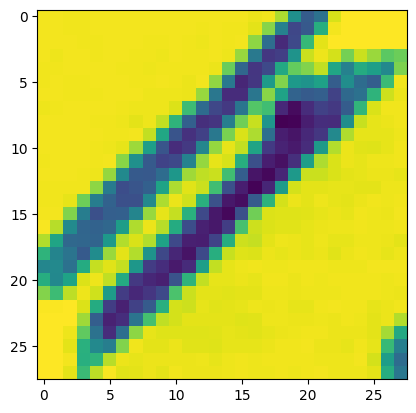

In [6]:
#Display a random image from the dataset (take any number from the random state)

idx = df_filtered.loc[df_filtered['transcription_encoded'] == Y_train[0]].index[0]
print('translation =', df_filtered['transcription'].iloc[idx])
plt.imshow(X_train[0])
plt.show()

* transforming data into 4-dimensional array (images, width, height, depth)
* One-hot encoding for labels

In [7]:
# Reshape for CNN
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

# Compute class weights to improve class balance
'''
class_weights = compute_class_weight(
 class_weight='balanced',
 classes=np.unique(Y_train),
 y=Y_train)

class_weights_dict = dict(zip(np.unique(Y_train), class_weights))

'''

# calculates class weights manually based on class distribution
class_counts = np.unique(Y_train, return_counts=True)[1]
max_count = np.max(class_counts)
smooth_factor = 1e-6

class_weights_manual = class_counts / max_count
class_weights_manual += smooth_factor

class_weights_dict_manual = {label: weight / np.sum(class_weights_manual) for label, weight in zip(np.unique(Y_train), class_weights_manual)}

# One-hot encoding for labels
num_classes = max(len(np.unique(Y_train)), len(np.unique(Y_test)))
y_train = to_categorical(Y_train, num_classes=num_classes)
y_test = to_categorical(Y_test, num_classes=num_classes)

# check if one hot encoding was successful
display(np.unique(Y_train).shape) #
display(y_train.shape) #
display(np.argmax(y_train)) #
display(len(np.unique(Y_train))) #

(6360,)

(86502, 6360)

4

6360

* Data Generator - slightly shifting images without producing overly disorted images

In [8]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 5)

test_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow(X_train,y_train, batch_size = 64)
test_dataset = test_datagen.flow(X_test, y_test, batch_size = 64)

* Implementing Callbacks
* EarlyStopping: stops training when monitored metrics stop improving (like validation accuracy) therefore preventing overfitting and saving computational recources
* ModelCheckpoint: saving the best-performing model according to monitored metric
* Worth exploring: ReduceLROnPlateau, LearningRateScheduler


In [9]:
early_stopping = EarlyStopping(
                                patience=30, # Wait 20 epochs before application
                                min_delta = 0.01, # if after 5 epochs the loss function does not vary by 1%, 
                                                  # either upwards or downwards, we stop.
                                verbose=1, # Show at which epoch we stop
                                mode = 'min',
                                monitor='val_accuracy') # monitoring val_accuracy

model_checkpoint = ModelCheckpoint(
                                    monitor="val_accuracy",
                                    save_best_only="True",
                                    mode="max",
                                    filepath="../model_checkpoint/CNN.keras"
                                    )

* CNN Architecture

* Creating and Training the model

In [10]:
# CNN Model
inputs_cnn = Input(shape=(28, 28, 1))  # Adjust shape for RGB
x = Conv2D(32, (5, 5), activation='relu')(inputs_cnn)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
num_classes = y_train.shape[1]  # Number of classes
outputs_cnn = Dense(num_classes, activation='softmax')(x)

# Compile model
model_cnn = Model(inputs=inputs_cnn, outputs=outputs_cnn)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
'''
training_history_cnn = model_cnn.fit(test_dataset,
                                     y_train,
                                     epochs=50,
                                     #batch_size=64, # recommended for ocr project: 32 or 64
                                     verbose=1,
                                     class_weight=class_weights_dict_manual,
                                     validation_data=(X_test, y_test),
                                     callbacks=[early_stopping, model_checkpoint])'''

training_history_cnn = model_cnn.fit(train_dataset,
                                     epochs=50,
                                     verbose=1,
                                     class_weight=class_weights_dict_manual,
                                     validation_data=test_dataset,
                                     callbacks=[early_stopping, model_checkpoint])


Epoch 1/50


/home/cloud/Documents/MachineLearningEngineer_Datascientest/project/OCR/OCR2/OCR_handwriting/OCR2_env/lib64/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 65s 47ms/step - accuracy: 0.1410 - loss: 0.0257 - val_accuracy: 0.2556 - val_loss: 6.3561
Epoch 2/50
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 54s 40ms/step - accuracy: 0.2438 - loss: 0.0119 - val_accuracy: 0.2897 - val_loss: 5.9954
Epoch 3/50
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 68s 50ms/step - accuracy: 0.2801 - loss: 0.0098 - val_accuracy: 0.3167 - val_loss: 5.8018
Epoch 4/50
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 75s 56ms/step - accuracy: 0.3017 - loss: 0.0086 - val_accuracy: 0.3496 - val_loss: 5.0479
Epoch 5/50
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 75s 56ms/step - accuracy: 0.3213 - loss: 0.0081 - val_accuracy: 0.3698 - val_loss: 4.8195
Epoch 6/50
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - accuracy: 0.3338 - loss: 0.0075 - val_accuracy: 0.3775 - val_loss: 4.6210
Epoch 7/50
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - accuracy: 0.3423 - loss: 0.0073 - val_accuracy: 0.3875 - val_loss: 4.7833
Epoch 8/50
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 62s 46ms/step - accuracy: 0.3509 - loss: 0.00

* Performance of the CNN model

* Plot of evolution of accuracies throughout the training

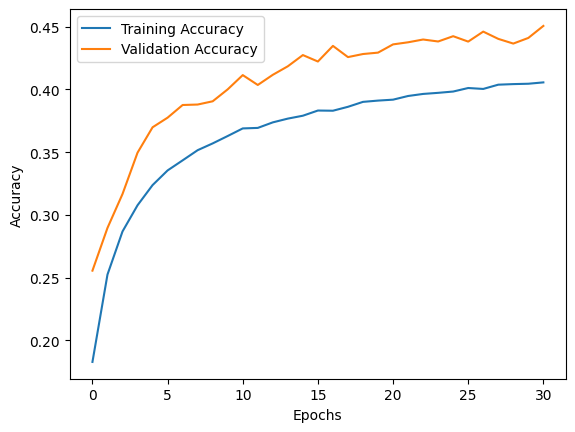

In [15]:
train_acc_cnn = training_history_cnn.history['accuracy']
val_acc_cnn = training_history_cnn.history['val_accuracy']

# Training sample accuracy curve
plt.plot(train_acc_cnn, label='Training Accuracy')
# Test sample accuracy curve
plt.plot(val_acc_cnn, label='Validation Accuracy')
# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* displaying detailed evaluative report of model's performance

In [12]:
test_pred = model_cnn.predict(X_test)
test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

#print(metrics.classification_report(y_test_class, test_pred_class))
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)

# Extracting mean values
mean_precision = report['weighted avg']['precision']
mean_recall = report['weighted avg']['recall']
mean_f1_score = report['weighted avg']['f1-score']

# Output the mean values
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-Score: {mean_f1_score:.2f}')

676/676 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step


/home/cloud/Documents/MachineLearningEngineer_Datascientest/project/OCR/OCR2/OCR_handwriting/OCR2_env/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cloud/Documents/MachineLearningEngineer_Datascientest/project/OCR/OCR2/OCR_handwriting/OCR2_env/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mean Precision: 0.37
Mean Recall: 0.45
Mean F1-Score: 0.36


/home/cloud/Documents/MachineLearningEngineer_Datascientest/project/OCR/OCR2/OCR_handwriting/OCR2_env/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* displaying confusion matrix between y_test_class and test_pred_class

In [13]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)

[[ 32   1   0 ...   0   0   0]
 [  2 231   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


* displaying random images that the model got wrong

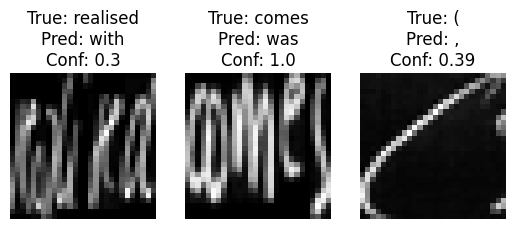

In [16]:
# Create mapping from class indices to transcriptions
class_mapping = {index: transcription for index, transcription in enumerate(pd.Series(Y).unique())}

# Handling error indexes
error_indexes = [i for i in range(len(test_pred)) if test_pred_class[i] != y_test_class[i]]

if len(error_indexes) > 0:
    j = 1
    for i in np.random.choice(error_indexes, size=min(3, len(error_indexes)), replace=False):
        img = X_test[i]
        plt.subplot(1, 3, j)
        plt.axis('off')
        plt.imshow(img, cmap=cm.binary)
        true_transcription = df_filtered.loc[df_filtered['transcription_encoded'] == Y_test[i], 'transcription'].iloc[0]
        predicted_transcription = df_filtered.loc[df_filtered['transcription_encoded'] == test_pred_class[i], 'transcription'].iloc[0]
        confidence = str(round(test_pred[i][test_pred_class[i]], 2))

        plt.title(f'True: {true_transcription}\nPred: {predicted_transcription}\nConf: {confidence}')
        j += 1
    plt.show()
else:
    print("No errors in predictions.")
              